# 1. Importing modules and functions

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import glob
xml_files = glob.glob("fingerprints_xml/*.xml")
xml_files.sort()
xml_files

['fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'fingerprints_xml\\EStateFingerprinter.xml',
 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'fingerprints_xml\\Fingerprinter.xml',
 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'fingerprints_xml\\MACCSFingerprinter.xml',
 'fingerprints_xml\\PubchemFingerprinter.xml',
 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'fingerprints_xml\\SubstructureFingerprinter.xml']

In [3]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'AtomPairs2D',
 'SubstructureCount',
 'Substructure']

In [4]:
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

# 2.Data entry and curation work set

In [5]:
uploaded_file_ws="datasets/HDAC6_work.sdf"
supplier_ws = Chem.ForwardSDMolSupplier(uploaded_file_ws,sanitize=False)
failed_mols_ws = []
all_mols_ws =[]
wrong_structure_ws=[]
wrong_smiles_ws=[]
y_tr = []
y_bad_index=[]

for i, m in enumerate(supplier_ws):
    structure = Chem.Mol(m)
    all_mols_ws.append(structure)
    y_tr.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ws.append(m)
        wrong_smiles_ws.append(Chem.MolToSmiles(m))
        wrong_structure_ws.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ws), 'molecules')
print('Failed data: ', len(failed_mols_ws), 'molecules')
number_ws =[]
for i in range(len(failed_mols_ws)):
        number_ws.append(str(i+1))
bad_molecules_ws = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ws, 'SMILES of wrong structure: ': wrong_smiles_ws, 'No.': number_ws}, index=None)
bad_molecules_ws = bad_molecules_ws.set_index('No.')
bad_molecules_ws

Original data:  3083 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [6]:
y_tr[:] = [x for i,x in enumerate(y_tr) if i not in y_bad_index]

In [7]:
len(y_tr)

3083

# 3.Standardization SDF file for work set

In [8]:
all_mols_ws[:] = [x for i,x in enumerate(all_mols_ws) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ws)):
    record = Chem.MolToSmiles(all_mols_ws[i])
    records.append(record)

moldf_ws = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ws.append(m)
    
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  3083 molecules


In [9]:
records_ws = []
for i in range(len(moldf_ws)):
    record = Chem.MolToSmiles(moldf_ws[i])
    records_ws.append(record)

In [10]:
df = pd.DataFrame(records_ws, columns=["Smiles"])
df.to_csv('datasets/molecule_ws.smi', sep=',', index=False, header=False)

# 4.Data entry and curation test set

In [11]:
uploaded_file_ts="datasets/HDAC6_test.sdf"
supplier_ts = Chem.ForwardSDMolSupplier(uploaded_file_ts,sanitize=False)
failed_mols_ts = []
all_mols_ts =[]
wrong_structure_ts=[]
wrong_smiles_ts=[]
y_ts = []
y_bad_index=[]
for i, m in enumerate(supplier_ts):
    structure = Chem.Mol(m)
    all_mols_ts.append(structure)
    y_ts.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ts.append(m)
        wrong_smiles_ts.append(Chem.MolToSmiles(m))
        wrong_structure_ts.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ts), 'molecules')
print('Failed data: ', len(failed_mols_ts), 'molecules')
number_ts =[]
for i in range(len(failed_mols_ts)):
        number_ts.append(str(i+1))
bad_molecules_ts = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ts, 'SMILES of wrong structure: ': wrong_smiles_ts, 'No.': number_ts}, index=None)
bad_molecules_ts = bad_molecules_ts.set_index('No.')
bad_molecules_ts

Original data:  771 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [12]:
y_ts[:] = [x for i,x in enumerate(y_ts) if i not in y_bad_index]

In [13]:
len(y_ts)

771

# 5.Standardization SDF file for test set

In [14]:
all_mols_ts[:] = [x for i,x in enumerate(all_mols_ts) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ts)):
    record = Chem.MolToSmiles(all_mols_ts[i])
    records.append(record)

moldf_ts = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ts.append(m)
    
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  771 molecules


In [15]:
records_ts = []
for i in range(len(moldf_ts)):
    record = Chem.MolToSmiles(moldf_ts[i])
    records_ts.append(record)

In [16]:
df_ts = pd.DataFrame(records_ts, columns=["Smiles"])
df_ts.to_csv('datasets/molecule_ts.smi', sep=',', index=False, header=False)

# 6.Descriptor calculation for work set

In [17]:
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

## AtomPairs2D FPs

In [163]:
from padelpy import padeldescriptor

fingerprint = 'AtomPairs2D'

fingerprint_output_file = ''.join([fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ws.smi', 
                d_file=fingerprint_output_file, #'Substructure.csv'
                #descriptortypes='SubstructureFingerprint.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [18]:
descriptors_AtomPairs2D = pd.read_csv('AtomPairs2D.csv')

In [19]:
descriptors_AtomPairs2D

,Name,AD2D1,AD2D2,AD2D3,AD2D4,AD2D5,AD2D6,AD2D7,AD2D8,AD2D9,...,AD2D771,AD2D772,AD2D773,AD2D774,AD2D775,AD2D776,AD2D777,AD2D778,AD2D779,AD2D780
0,AUTOGEN_molecule_ws_1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_molecule_ws_2,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_molecule_ws_3,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_molecule_ws_4,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_molecule_ws_5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,AUTOGEN_molecule_ws_3079,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3079,AUTOGEN_molecule_ws_3080,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3080,AUTOGEN_molecule_ws_3081,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3081,AUTOGEN_molecule_ws_3082,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
x_tr = descriptors_AtomPairs2D.drop('Name', axis=1)

In [21]:
x_tr = np.array(x_tr, dtype=np.float32)
y_tr = np.array(y_tr, dtype=np.float32)

In [23]:
savetxt('Models/Padels/x_tr_AtomPairs2D.csv', x_tr, delimiter=',')

In [24]:
x_tr.shape

(3083, 780)

# 7.Descriptor calculation for test set

In [179]:
from padelpy import padeldescriptor

fingerprint = 'AtomPairs2D'

fingerprint_output_file = ''.join([fingerprint,'_ts.csv']) #AtomPairs2D.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ts.smi', 
                d_file=fingerprint_output_file, #'AtomPairs2D.csv'
                #descriptortypes='AtomPairs2D.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=False,
                fingerprints=True)

In [25]:
descriptors_AtomPairs2D_ts = pd.read_csv('AtomPairs2D_ts.csv')

In [26]:
x_ts = descriptors_AtomPairs2D_ts.drop('Name', axis=1)

In [27]:
x_ts.shape

(771, 780)

 # GradientBoostingRegressor model building and validation

In [29]:
seed = 42

In [30]:
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [31]:
param_grid = {'learning_rate': [0.02,0.05],
                  'subsample'    : [0.9, 0.5, 0.1],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4, 10]
                 }

In [32]:
m = GridSearchCV(GradientBoostingRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [33]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.05], 'max_depth': [4, 10],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.9, 0.5, 0.1]},
             verbose=1)

In [34]:
best_GBR = m.best_estimator_

In [35]:
m.best_params_

{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.5}

In [36]:
y_pred_ws_GBR = best_GBR.predict(x_tr)

In [37]:
R2_WS = round(r2_score(y_tr, y_pred_ws_GBR), 2)
R2_WS

0.84

In [38]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_GBR)), 2)
RMSE_WS

0.56

In [39]:
y_pred_CV_GBR = cross_val_predict(best_GBR, x_tr, y_tr, cv=cv)

In [40]:
y_pred_CV_GBR

array([5.39345566, 5.31961002, 5.96141753, ..., 7.18004399, 8.29817527,
       7.38948281])

In [41]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.54

In [42]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.75

# 9. Prediction for test set's molecules

In [43]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)
len(y_ts)

771

In [44]:
y_pred_GBR = best_GBR.predict(x_ts)

In [45]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.57

In [46]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.73

# save the model to disk

In [47]:
pickle.dump(best_GBR, open('Models/Padels/HDAC6_GBR_AtomPairs2D.pkl', 'wb'))

# load the model from disk

In [26]:
best_GBR = pickle.load(open('Models/Padels/HDAC6_GBR_AtomPairs2D.pkl', 'rb'))

# 10. Y-randomization GradientBoostingRegressor model

In [48]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_GBR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   56.5s


True score =  0.54 
Y-randomization =  -0.16 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [49]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [50]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.000000,4.000000,2.449490,0.000000,3.316625,0.000000,3.000000,1.732051,1.414214,3.872983,...,1.414214,2.645751,1.414214,1.000000,0.000000,0.000000,0.000000,2.449490,1.000000,1.414214
2,2.828427,4.123106,2.449490,0.000000,3.872983,3.000000,3.162278,1.732051,2.645751,4.358899,...,1.414214,2.645751,1.732051,1.000000,0.000000,2.000000,1.000000,2.645751,1.732051,1.414214
3,3.000000,4.123106,2.645751,0.000000,4.000000,3.000000,3.162278,1.732051,2.828427,4.690416,...,1.732051,3.000000,2.000000,1.000000,0.000000,2.645751,1.000000,2.645751,1.732051,1.414214
4,3.000000,4.123106,2.645751,0.000000,4.000000,3.000000,3.162278,2.000000,2.828427,4.690416,...,2.000000,3.872983,2.000000,1.000000,0.000000,3.464102,1.414214,2.828427,1.732051,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,9.539392,9.486833,9.380832,9.643651,10.583005,9.486833,9.643651,9.433981,8.944272,10.198039,...,9.273619,8.602325,9.110434,9.327379,9.273619,8.717798,9.380832,8.831760,9.433981,9.327379
3079,9.591663,9.539392,9.433981,9.695360,10.630146,9.486833,9.695360,9.433981,9.110434,10.198039,...,9.273619,8.602325,9.110434,9.327379,9.273619,8.717798,9.380832,8.888194,9.433981,9.327379
3080,9.797959,9.539392,9.433981,9.746795,10.677078,9.539392,9.746795,9.486833,9.110434,10.198039,...,9.273619,8.602325,9.327379,9.380832,9.327379,8.717798,9.433981,9.000000,9.486833,9.380832
3081,9.797959,9.591663,9.643651,9.949874,10.862781,9.746795,9.746795,9.695360,9.273619,10.246951,...,9.486833,8.660254,9.433981,9.591663,9.539392,8.717798,9.643651,9.055386,9.643651,9.591663


In [51]:
similarity= neighbors_k

In [52]:
Dmean=np.mean(similarity[1,:])

In [53]:
round(Dmean, 2)

1.14

In [54]:
std=np.std(similarity[1,:])

In [55]:
round(std, 2)

1.27

In [56]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

1.77


In [57]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [58]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,770
0,2.828427,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.449490,2.645751,1.000000,0.000000,0.000000,3.316625,0.000000,3.605551,1.732051,0.000000
1,3.162278,2.000000,0.000000,2.449490,1.000000,1.414214,1.414214,0.000000,0.000000,0.000000,...,3.162278,2.645751,1.000000,0.000000,0.000000,3.464102,2.645751,3.741657,1.732051,0.000000
2,3.162278,2.000000,0.000000,2.449490,1.414214,3.000000,1.414214,0.000000,0.000000,0.000000,...,3.162278,2.645751,1.732051,1.414214,0.000000,3.464102,2.645751,3.872983,2.000000,1.000000
3,3.316625,2.000000,1.000000,2.645751,2.449490,3.000000,1.414214,0.000000,3.464102,1.414214,...,3.316625,2.645751,1.732051,1.414214,0.000000,3.464102,3.000000,4.000000,2.000000,1.000000
4,3.316625,2.000000,1.414214,2.645751,2.449490,3.162278,1.414214,0.000000,3.872983,1.414214,...,3.464102,3.000000,2.000000,1.414214,0.000000,3.464102,3.872983,4.000000,2.000000,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,10.099504,9.433981,9.380832,9.380832,9.273619,9.055386,9.219544,9.327379,9.539392,9.486833,...,8.888194,8.944272,9.165152,9.165152,9.380832,9.380832,8.602325,9.273619,9.165152,9.380832
3079,10.148891,9.486833,9.380832,9.380832,9.327379,9.165152,9.219544,9.380832,9.591663,9.486833,...,9.110434,8.944272,9.219544,9.165152,9.380832,9.433981,8.602325,9.273619,9.165152,9.380832
3080,10.246951,9.486833,9.433981,9.433981,9.380832,9.219544,9.273619,9.380832,9.591663,9.539392,...,9.110434,8.944272,9.219544,9.219544,9.433981,9.486833,8.602325,9.273619,9.165152,9.433981
3081,10.344080,9.695360,9.643651,9.486833,9.433981,9.219544,9.486833,9.433981,9.643651,9.746795,...,9.165152,9.000000,9.433981,9.273619,9.643651,9.539392,8.660254,9.327379,9.380832,9.643651


In [59]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[2.828 2.    0.    2.    0.    0.    0.    0.    0.    0.    0.    0.
 1.732 1.732 1.    1.732 0.    0.    2.646 0.    2.449 1.    1.    0.
 3.    0.    2.646 3.162 0.    1.732 0.    1.732 1.414 1.732 3.606 1.
 0.    1.732 0.    1.732 1.    0.    0.    2.    1.    1.    2.236 0.
 0.    1.    1.732 0.    3.606 1.    0.    0.    1.414 0.    1.414 0.
 0.    1.    1.    2.236 1.414 2.449 2.449 0.    2.    1.732 5.    0.
 0.    0.    0.    1.    0.    1.    1.414 0.    1.    0.    3.162 0.
 2.828 2.236 1.414 0.    2.236 0.    2.    3.162 0.    0.    0.    2.
 2.    3.317 1.414 2.449 1.    1.414 0.    2.236 2.236 2.449 0.    2.449
 1.414 2.    1.414 3.    0.    2.646 0.    0.    0.    0.    1.    0.
 0.    0.    1.414 3.606 3.317 0.    0.    0.    0.    1.414 2.828 0.
 1.414 1.    2.449 2.646 4.69  0.    2.    0.    1.    1.    2.449 0.
 3.162 0.    2.236 0.    2.    1.    0.    0.    3.464 1.732 1.732 2.828
 2.449 2.    2.236 0.    0.    2.828 2.646 4.243 2.236 0.    3.317 1.
 0.    0.    1

In [60]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False False  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False  True  True  True
 False  True False False  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True False  True  True False  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True False  True False False  True False  True False  True
  True  True  True  True  True  True  True  True  True  True False  True
 False False  True  True False  True False False  True  True  True False
 False False  True False  True  True  True False False False  True False
  True False  True False  True False  True  True  True  True  True  True
  True  True  True False False  True  True  True  True  True False  True
  True  True False False False  True False  True  True  True False  True
 False  True False  True False  True  True  True False  True  True False
 False False False  True  True False False False Fa

In [61]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.76


In [62]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  19  21  22
  23  25  28  29  30  31  32  33  35  36  37  38  39  40  41  42  44  45
  47  48  49  50  51  53  54  55  56  57  58  59  60  61  62  64  67  69
  71  72  73  74  75  76  77  78  79  80  81  83  86  87  89  92  93  94
  98 100 101 102 106 108 110 112 114 115 116 117 118 119 120 121 122 125
 126 127 128 129 131 132 133 137 139 140 141 143 145 147 149 150 151 153
 154 159 160 165 167 168 169 170 172 174 176 177 178 180 181 182 183 184
 185 186 188 189 191 193 195 196 197 198 199 201 202 203 206 207 208 210
 212 213 214 215 217 218 219 220 221 222 223 224 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 244 245 246 247 248 249 250
 251 252 253 254 255 256 257 259 261 262 264 265 266 267 270 272 273 275
 276 277 278 282 283 284 286 287 288 289 290 291 292 293 294 295 297 298
 299 300 301 302 303 304 305 306 308 309 310 313 314 316 317 318 319 320
 321 325 32

In [63]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [64]:
y_pred_GBR_ad=list(y_pred_GBR)

In [65]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [66]:
len(y_pred_GBR_ad)

586

In [67]:
y_ts_ad=list(y_ts)

In [68]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [69]:
len(y_ts_ad)

586

In [70]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.62

In [71]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.71

# SVM model building and validation

In [72]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [73]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [74]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [75]:
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [76]:
svm.best_params_
best_svm = svm.best_estimator_

In [77]:
svm.best_params_

{'C': 1, 'gamma': 0.1}

In [78]:
y_pred_ws_svm = best_svm.predict(x_tr)

In [79]:
R2_WS = round(r2_score(y_tr, y_pred_ws_svm), 2)
R2_WS

0.74

In [80]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_svm)), 2)
RMSE_WS

0.63

In [81]:
y_pred_CV_svm = cross_val_predict(best_svm, x_tr, y_tr, cv=cv)

In [82]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.5

In [83]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.77

# 9. Prediction for test set's molecules

In [84]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [85]:
y_pred_svm = best_svm.predict(x_ts)

In [86]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.53

In [87]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.76

save the model to disk

In [88]:
pickle.dump(best_svm, open('Models/Padels/HDAC6_SVM_AtomPairs2D.pkl', 'wb'))

load the model from disk

In [31]:
best_svm = pickle.load(open('Models/Padels/HDAC6_SVM_AtomPairs2D.pkl', 'rb'))

# 10. Y-randomization SVM model

In [89]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_svm, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(3),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.6min


True score =  0.498 
Y-randomization =  -0.1 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.7min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [90]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [91]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.000000,4.000000,2.449490,0.000000,3.316625,0.000000,3.000000,1.732051,1.414214,3.872983,...,1.414214,2.645751,1.414214,1.000000,0.000000,0.000000,0.000000,2.449490,1.000000,1.414214
2,2.828427,4.123106,2.449490,0.000000,3.872983,3.000000,3.162278,1.732051,2.645751,4.358899,...,1.414214,2.645751,1.732051,1.000000,0.000000,2.000000,1.000000,2.645751,1.732051,1.414214
3,3.000000,4.123106,2.645751,0.000000,4.000000,3.000000,3.162278,1.732051,2.828427,4.690416,...,1.732051,3.000000,2.000000,1.000000,0.000000,2.645751,1.000000,2.645751,1.732051,1.414214
4,3.000000,4.123106,2.645751,0.000000,4.000000,3.000000,3.162278,2.000000,2.828427,4.690416,...,2.000000,3.872983,2.000000,1.000000,0.000000,3.464102,1.414214,2.828427,1.732051,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,9.539392,9.486833,9.380832,9.643651,10.583005,9.486833,9.643651,9.433981,8.944272,10.198039,...,9.273619,8.602325,9.110434,9.327379,9.273619,8.717798,9.380832,8.831760,9.433981,9.327379
3079,9.591663,9.539392,9.433981,9.695360,10.630146,9.486833,9.695360,9.433981,9.110434,10.198039,...,9.273619,8.602325,9.110434,9.327379,9.273619,8.717798,9.380832,8.888194,9.433981,9.327379
3080,9.797959,9.539392,9.433981,9.746795,10.677078,9.539392,9.746795,9.486833,9.110434,10.198039,...,9.273619,8.602325,9.327379,9.380832,9.327379,8.717798,9.433981,9.000000,9.486833,9.380832
3081,9.797959,9.591663,9.643651,9.949874,10.862781,9.746795,9.746795,9.695360,9.273619,10.246951,...,9.486833,8.660254,9.433981,9.591663,9.539392,8.717798,9.643651,9.055386,9.643651,9.591663


In [92]:
similarity= neighbors_k

In [93]:
Dmean=np.mean(similarity[1,:])

In [94]:
round(Dmean, 2)

1.14

In [95]:
std=np.std(similarity[1,:])

In [96]:
round(std, 2)

1.27

In [97]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

1.77


In [98]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [99]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,770
0,2.828427,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.449490,2.645751,1.000000,0.000000,0.000000,3.316625,0.000000,3.605551,1.732051,0.000000
1,3.162278,2.000000,0.000000,2.449490,1.000000,1.414214,1.414214,0.000000,0.000000,0.000000,...,3.162278,2.645751,1.000000,0.000000,0.000000,3.464102,2.645751,3.741657,1.732051,0.000000
2,3.162278,2.000000,0.000000,2.449490,1.414214,3.000000,1.414214,0.000000,0.000000,0.000000,...,3.162278,2.645751,1.732051,1.414214,0.000000,3.464102,2.645751,3.872983,2.000000,1.000000
3,3.316625,2.000000,1.000000,2.645751,2.449490,3.000000,1.414214,0.000000,3.464102,1.414214,...,3.316625,2.645751,1.732051,1.414214,0.000000,3.464102,3.000000,4.000000,2.000000,1.000000
4,3.316625,2.000000,1.414214,2.645751,2.449490,3.162278,1.414214,0.000000,3.872983,1.414214,...,3.464102,3.000000,2.000000,1.414214,0.000000,3.464102,3.872983,4.000000,2.000000,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,10.099504,9.433981,9.380832,9.380832,9.273619,9.055386,9.219544,9.327379,9.539392,9.486833,...,8.888194,8.944272,9.165152,9.165152,9.380832,9.380832,8.602325,9.273619,9.165152,9.380832
3079,10.148891,9.486833,9.380832,9.380832,9.327379,9.165152,9.219544,9.380832,9.591663,9.486833,...,9.110434,8.944272,9.219544,9.165152,9.380832,9.433981,8.602325,9.273619,9.165152,9.380832
3080,10.246951,9.486833,9.433981,9.433981,9.380832,9.219544,9.273619,9.380832,9.591663,9.539392,...,9.110434,8.944272,9.219544,9.219544,9.433981,9.486833,8.602325,9.273619,9.165152,9.433981
3081,10.344080,9.695360,9.643651,9.486833,9.433981,9.219544,9.486833,9.433981,9.643651,9.746795,...,9.165152,9.000000,9.433981,9.273619,9.643651,9.539392,8.660254,9.327379,9.380832,9.643651


In [100]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[2.828 2.    0.    2.    0.    0.    0.    0.    0.    0.    0.    0.
 1.732 1.732 1.    1.732 0.    0.    2.646 0.    2.449 1.    1.    0.
 3.    0.    2.646 3.162 0.    1.732 0.    1.732 1.414 1.732 3.606 1.
 0.    1.732 0.    1.732 1.    0.    0.    2.    1.    1.    2.236 0.
 0.    1.    1.732 0.    3.606 1.    0.    0.    1.414 0.    1.414 0.
 0.    1.    1.    2.236 1.414 2.449 2.449 0.    2.    1.732 5.    0.
 0.    0.    0.    1.    0.    1.    1.414 0.    1.    0.    3.162 0.
 2.828 2.236 1.414 0.    2.236 0.    2.    3.162 0.    0.    0.    2.
 2.    3.317 1.414 2.449 1.    1.414 0.    2.236 2.236 2.449 0.    2.449
 1.414 2.    1.414 3.    0.    2.646 0.    0.    0.    0.    1.    0.
 0.    0.    1.414 3.606 3.317 0.    0.    0.    0.    1.414 2.828 0.
 1.414 1.    2.449 2.646 4.69  0.    2.    0.    1.    1.    2.449 0.
 3.162 0.    2.236 0.    2.    1.    0.    0.    3.464 1.732 1.732 2.828
 2.449 2.    2.236 0.    0.    2.828 2.646 4.243 2.236 0.    3.317 1.
 0.    0.    1

In [101]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False False  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False  True  True  True
 False  True False False  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True False  True  True False  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True False  True False False  True False  True False  True
  True  True  True  True  True  True  True  True  True  True False  True
 False False  True  True False  True False False  True  True  True False
 False False  True False  True  True  True False False False  True False
  True False  True False  True False  True  True  True  True  True  True
  True  True  True False False  True  True  True  True  True False  True
  True  True False False False  True False  True  True  True False  True
 False  True False  True False  True  True  True False  True  True False
 False False False  True  True False False False Fa

In [102]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.76


In [103]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  19  21  22
  23  25  28  29  30  31  32  33  35  36  37  38  39  40  41  42  44  45
  47  48  49  50  51  53  54  55  56  57  58  59  60  61  62  64  67  69
  71  72  73  74  75  76  77  78  79  80  81  83  86  87  89  92  93  94
  98 100 101 102 106 108 110 112 114 115 116 117 118 119 120 121 122 125
 126 127 128 129 131 132 133 137 139 140 141 143 145 147 149 150 151 153
 154 159 160 165 167 168 169 170 172 174 176 177 178 180 181 182 183 184
 185 186 188 189 191 193 195 196 197 198 199 201 202 203 206 207 208 210
 212 213 214 215 217 218 219 220 221 222 223 224 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 244 245 246 247 248 249 250
 251 252 253 254 255 256 257 259 261 262 264 265 266 267 270 272 273 275
 276 277 278 282 283 284 286 287 288 289 290 291 292 293 294 295 297 298
 299 300 301 302 303 304 305 306 308 309 310 313 314 316 317 318 319 320
 321 325 32

In [104]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [105]:
y_pred_svm_ad=list(y_pred_svm)

In [106]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [107]:
len(y_pred_svm_ad)

586

In [108]:
y_ts_ad=list(y_ts)

In [109]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [110]:
len(y_ts_ad)

586

In [111]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.59

In [112]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.72

# Multi-layer Perceptron regressor

In [113]:
from sklearn.neural_network import MLPRegressor

In [114]:
param_grid ={"hidden_layer_sizes": [(400, 300, 200, 100),(100, 100, 100), (10, 10, 10),(50,)], "activation": ["tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005], 'max_iter': [1000, 2000]}

In [115]:
m = GridSearchCV(MLPRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [116]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [5e-05, 0.0005],
                         'hidden_layer_sizes': [(400, 300, 200, 100),
                                                (100, 100, 100), (10, 10, 10),
                                                (50,)],
                         'max_iter': [1000, 2000],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=1)

In [117]:
best_MLPR = m.best_estimator_

In [118]:
m.best_params_

{'activation': 'relu',
 'alpha': 5e-05,
 'hidden_layer_sizes': (400, 300, 200, 100),
 'max_iter': 2000,
 'solver': 'sgd'}

In [119]:
y_pred_ws_MLPR = best_MLPR.predict(x_tr)

In [120]:
R2_WS = round(r2_score(y_tr, y_pred_ws_MLPR), 2)
R2_WS

0.78

In [121]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_MLPR)), 2)
RMSE_WS

0.61

In [122]:
y_pred_CV_MLPR = cross_val_predict(best_MLPR, x_tr, y_tr, cv=cv)

In [123]:
y_pred_CV_MLPR

array([6.262635 , 6.247747 , 5.7088637, ..., 6.7430563, 8.32467  ,
       7.482917 ], dtype=float32)

In [124]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_MLPR), 2)
Q2_CV

0.46

In [125]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_MLPR)), 2)
RMSE_CV

0.78

# 9. Prediction for test set's molecules

In [126]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [127]:
y_pred_MLPR = best_MLPR.predict(x_ts)

In [128]:
Q2_TS = round(r2_score(y_ts, y_pred_MLPR), 2)
Q2_TS

0.52

In [129]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_MLPR)), 2)
RMSE_TS

0.77

# save the model to disk

In [130]:
pickle.dump(best_MLPR, open('Models/Padels/HDAC6_MLPR_AtomPairs2D.pkl', 'wb'))

# load the model from disk

In [87]:
best_MLPR = pickle.load(open('Models/Padels/HDAC6_MLPR_AtomPairs2D.pkl', 'rb'))

# 10. Y-randomization MLPR

In [131]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_MLPR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 55.3min


True score =  0.45 
Y-randomization =  -0.36 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 92.5min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [132]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [133]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.000000,4.000000,2.449490,0.000000,3.316625,0.000000,3.000000,1.732051,1.414214,3.872983,...,1.414214,2.645751,1.414214,1.000000,0.000000,0.000000,0.000000,2.449490,1.000000,1.414214
2,2.828427,4.123106,2.449490,0.000000,3.872983,3.000000,3.162278,1.732051,2.645751,4.358899,...,1.414214,2.645751,1.732051,1.000000,0.000000,2.000000,1.000000,2.645751,1.732051,1.414214
3,3.000000,4.123106,2.645751,0.000000,4.000000,3.000000,3.162278,1.732051,2.828427,4.690416,...,1.732051,3.000000,2.000000,1.000000,0.000000,2.645751,1.000000,2.645751,1.732051,1.414214
4,3.000000,4.123106,2.645751,0.000000,4.000000,3.000000,3.162278,2.000000,2.828427,4.690416,...,2.000000,3.872983,2.000000,1.000000,0.000000,3.464102,1.414214,2.828427,1.732051,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,9.539392,9.486833,9.380832,9.643651,10.583005,9.486833,9.643651,9.433981,8.944272,10.198039,...,9.273619,8.602325,9.110434,9.327379,9.273619,8.717798,9.380832,8.831760,9.433981,9.327379
3079,9.591663,9.539392,9.433981,9.695360,10.630146,9.486833,9.695360,9.433981,9.110434,10.198039,...,9.273619,8.602325,9.110434,9.327379,9.273619,8.717798,9.380832,8.888194,9.433981,9.327379
3080,9.797959,9.539392,9.433981,9.746795,10.677078,9.539392,9.746795,9.486833,9.110434,10.198039,...,9.273619,8.602325,9.327379,9.380832,9.327379,8.717798,9.433981,9.000000,9.486833,9.380832
3081,9.797959,9.591663,9.643651,9.949874,10.862781,9.746795,9.746795,9.695360,9.273619,10.246951,...,9.486833,8.660254,9.433981,9.591663,9.539392,8.717798,9.643651,9.055386,9.643651,9.591663


In [134]:
similarity= neighbors_k

In [135]:
Dmean=np.mean(similarity[1,:])

In [136]:
round(Dmean, 2)

1.14

In [137]:
std=np.std(similarity[1,:])

In [138]:
round(std, 2)

1.27

In [139]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

1.77


In [140]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [141]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,770
0,2.828427,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.449490,2.645751,1.000000,0.000000,0.000000,3.316625,0.000000,3.605551,1.732051,0.000000
1,3.162278,2.000000,0.000000,2.449490,1.000000,1.414214,1.414214,0.000000,0.000000,0.000000,...,3.162278,2.645751,1.000000,0.000000,0.000000,3.464102,2.645751,3.741657,1.732051,0.000000
2,3.162278,2.000000,0.000000,2.449490,1.414214,3.000000,1.414214,0.000000,0.000000,0.000000,...,3.162278,2.645751,1.732051,1.414214,0.000000,3.464102,2.645751,3.872983,2.000000,1.000000
3,3.316625,2.000000,1.000000,2.645751,2.449490,3.000000,1.414214,0.000000,3.464102,1.414214,...,3.316625,2.645751,1.732051,1.414214,0.000000,3.464102,3.000000,4.000000,2.000000,1.000000
4,3.316625,2.000000,1.414214,2.645751,2.449490,3.162278,1.414214,0.000000,3.872983,1.414214,...,3.464102,3.000000,2.000000,1.414214,0.000000,3.464102,3.872983,4.000000,2.000000,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,10.099504,9.433981,9.380832,9.380832,9.273619,9.055386,9.219544,9.327379,9.539392,9.486833,...,8.888194,8.944272,9.165152,9.165152,9.380832,9.380832,8.602325,9.273619,9.165152,9.380832
3079,10.148891,9.486833,9.380832,9.380832,9.327379,9.165152,9.219544,9.380832,9.591663,9.486833,...,9.110434,8.944272,9.219544,9.165152,9.380832,9.433981,8.602325,9.273619,9.165152,9.380832
3080,10.246951,9.486833,9.433981,9.433981,9.380832,9.219544,9.273619,9.380832,9.591663,9.539392,...,9.110434,8.944272,9.219544,9.219544,9.433981,9.486833,8.602325,9.273619,9.165152,9.433981
3081,10.344080,9.695360,9.643651,9.486833,9.433981,9.219544,9.486833,9.433981,9.643651,9.746795,...,9.165152,9.000000,9.433981,9.273619,9.643651,9.539392,8.660254,9.327379,9.380832,9.643651


In [142]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[2.828 2.    0.    2.    0.    0.    0.    0.    0.    0.    0.    0.
 1.732 1.732 1.    1.732 0.    0.    2.646 0.    2.449 1.    1.    0.
 3.    0.    2.646 3.162 0.    1.732 0.    1.732 1.414 1.732 3.606 1.
 0.    1.732 0.    1.732 1.    0.    0.    2.    1.    1.    2.236 0.
 0.    1.    1.732 0.    3.606 1.    0.    0.    1.414 0.    1.414 0.
 0.    1.    1.    2.236 1.414 2.449 2.449 0.    2.    1.732 5.    0.
 0.    0.    0.    1.    0.    1.    1.414 0.    1.    0.    3.162 0.
 2.828 2.236 1.414 0.    2.236 0.    2.    3.162 0.    0.    0.    2.
 2.    3.317 1.414 2.449 1.    1.414 0.    2.236 2.236 2.449 0.    2.449
 1.414 2.    1.414 3.    0.    2.646 0.    0.    0.    0.    1.    0.
 0.    0.    1.414 3.606 3.317 0.    0.    0.    0.    1.414 2.828 0.
 1.414 1.    2.449 2.646 4.69  0.    2.    0.    1.    1.    2.449 0.
 3.162 0.    2.236 0.    2.    1.    0.    0.    3.464 1.732 1.732 2.828
 2.449 2.    2.236 0.    0.    2.828 2.646 4.243 2.236 0.    3.317 1.
 0.    0.    1

In [143]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False False  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False  True  True  True
 False  True False False  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True False  True  True False  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True False  True False False  True False  True False  True
  True  True  True  True  True  True  True  True  True  True False  True
 False False  True  True False  True False False  True  True  True False
 False False  True False  True  True  True False False False  True False
  True False  True False  True False  True  True  True  True  True  True
  True  True  True False False  True  True  True  True  True False  True
  True  True False False False  True False  True  True  True False  True
 False  True False  True False  True  True  True False  True  True False
 False False False  True  True False False False Fa

In [144]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.76


In [145]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  19  21  22
  23  25  28  29  30  31  32  33  35  36  37  38  39  40  41  42  44  45
  47  48  49  50  51  53  54  55  56  57  58  59  60  61  62  64  67  69
  71  72  73  74  75  76  77  78  79  80  81  83  86  87  89  92  93  94
  98 100 101 102 106 108 110 112 114 115 116 117 118 119 120 121 122 125
 126 127 128 129 131 132 133 137 139 140 141 143 145 147 149 150 151 153
 154 159 160 165 167 168 169 170 172 174 176 177 178 180 181 182 183 184
 185 186 188 189 191 193 195 196 197 198 199 201 202 203 206 207 208 210
 212 213 214 215 217 218 219 220 221 222 223 224 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 244 245 246 247 248 249 250
 251 252 253 254 255 256 257 259 261 262 264 265 266 267 270 272 273 275
 276 277 278 282 283 284 286 287 288 289 290 291 292 293 294 295 297 298
 299 300 301 302 303 304 305 306 308 309 310 313 314 316 317 318 319 320
 321 325 32

In [146]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [147]:
y_pred_MLPR_ad=list(y_pred_MLPR)

In [148]:
y_pred_MLPR_ad[:] = [x for i,x in enumerate(y_pred_MLPR_ad) if i not in out_Ad]

In [149]:
len(y_pred_MLPR_ad)

586

In [150]:
y_ts_ad=list(y_ts)

In [151]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [152]:
len(y_ts_ad)

586

In [153]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_MLPR_ad), 2)
Q2_TS

0.58

In [154]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_MLPR_ad)), 2)
RMSE_TS

0.73

# k-nearest neighbors

In [155]:
from sklearn.neighbors import KNeighborsRegressor

In [156]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

In [157]:
m = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [158]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=1)

In [159]:
best_kNN = m.best_estimator_

In [160]:
m.best_params_

{'n_neighbors': 8}

In [161]:
y_pred_ws_kNN = best_kNN.predict(x_tr)

In [162]:
R2_WS = round(r2_score(y_tr, y_pred_ws_kNN), 2)
R2_WS

0.56

In [163]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_kNN)), 2)
RMSE_WS

0.74

In [164]:
y_pred_CV_kNN = cross_val_predict(best_kNN, x_tr, y_tr, cv=cv)

In [165]:
y_pred_CV_kNN

array([6.364375 , 6.0891666, 6.5975   , ..., 7.42125  , 8.22875  ,
       7.506875 ], dtype=float32)

In [166]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_kNN), 2)
Q2_CV

0.41

In [167]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_kNN)), 2)
RMSE_CV

0.8

# 9. Prediction for test set's molecules

In [168]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [169]:
y_pred_kNN = best_kNN.predict(x_ts)

In [170]:
Q2_TS = round(r2_score(y_ts, y_pred_kNN), 2)
Q2_TS

0.44

In [171]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_kNN)), 2)
RMSE_TS

0.8

# save the model to disk

In [172]:
pickle.dump(best_kNN, open('Models/Padels/HDAC6_kNN_AtomPairs2D.pkl', 'wb'))

# load the model from disk

In [173]:
best_kNN = pickle.load(open('Models/Padels/HDAC6_kNN_AtomPairs2D.pkl', 'rb'))

# 10. Y-randomization MLPR

In [174]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_kNN, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.0s


True score =  0.41 
Y-randomization =  -0.13 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.2s finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [175]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [176]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,3073,3074,3075,3076,3077,3078,3079,3080,3081,3082
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.000000,4.000000,2.449490,0.000000,3.316625,0.000000,3.000000,1.732051,1.414214,3.872983,...,1.414214,2.645751,1.414214,1.000000,0.000000,0.000000,0.000000,2.449490,1.000000,1.414214
2,2.828427,4.123106,2.449490,0.000000,3.872983,3.000000,3.162278,1.732051,2.645751,4.358899,...,1.414214,2.645751,1.732051,1.000000,0.000000,2.000000,1.000000,2.645751,1.732051,1.414214
3,3.000000,4.123106,2.645751,0.000000,4.000000,3.000000,3.162278,1.732051,2.828427,4.690416,...,1.732051,3.000000,2.000000,1.000000,0.000000,2.645751,1.000000,2.645751,1.732051,1.414214
4,3.000000,4.123106,2.645751,0.000000,4.000000,3.000000,3.162278,2.000000,2.828427,4.690416,...,2.000000,3.872983,2.000000,1.000000,0.000000,3.464102,1.414214,2.828427,1.732051,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,9.539392,9.486833,9.380832,9.643651,10.583005,9.486833,9.643651,9.433981,8.944272,10.198039,...,9.273619,8.602325,9.110434,9.327379,9.273619,8.717798,9.380832,8.831760,9.433981,9.327379
3079,9.591663,9.539392,9.433981,9.695360,10.630146,9.486833,9.695360,9.433981,9.110434,10.198039,...,9.273619,8.602325,9.110434,9.327379,9.273619,8.717798,9.380832,8.888194,9.433981,9.327379
3080,9.797959,9.539392,9.433981,9.746795,10.677078,9.539392,9.746795,9.486833,9.110434,10.198039,...,9.273619,8.602325,9.327379,9.380832,9.327379,8.717798,9.433981,9.000000,9.486833,9.380832
3081,9.797959,9.591663,9.643651,9.949874,10.862781,9.746795,9.746795,9.695360,9.273619,10.246951,...,9.486833,8.660254,9.433981,9.591663,9.539392,8.717798,9.643651,9.055386,9.643651,9.591663


In [177]:
similarity= neighbors_k

In [178]:
Dmean=np.mean(similarity[1,:])

In [179]:
round(Dmean, 2)

1.14

In [180]:
std=np.std(similarity[1,:])

In [181]:
round(std, 2)

1.27

In [182]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

1.77


In [183]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [184]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,770
0,2.828427,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.449490,2.645751,1.000000,0.000000,0.000000,3.316625,0.000000,3.605551,1.732051,0.000000
1,3.162278,2.000000,0.000000,2.449490,1.000000,1.414214,1.414214,0.000000,0.000000,0.000000,...,3.162278,2.645751,1.000000,0.000000,0.000000,3.464102,2.645751,3.741657,1.732051,0.000000
2,3.162278,2.000000,0.000000,2.449490,1.414214,3.000000,1.414214,0.000000,0.000000,0.000000,...,3.162278,2.645751,1.732051,1.414214,0.000000,3.464102,2.645751,3.872983,2.000000,1.000000
3,3.316625,2.000000,1.000000,2.645751,2.449490,3.000000,1.414214,0.000000,3.464102,1.414214,...,3.316625,2.645751,1.732051,1.414214,0.000000,3.464102,3.000000,4.000000,2.000000,1.000000
4,3.316625,2.000000,1.414214,2.645751,2.449490,3.162278,1.414214,0.000000,3.872983,1.414214,...,3.464102,3.000000,2.000000,1.414214,0.000000,3.464102,3.872983,4.000000,2.000000,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078,10.099504,9.433981,9.380832,9.380832,9.273619,9.055386,9.219544,9.327379,9.539392,9.486833,...,8.888194,8.944272,9.165152,9.165152,9.380832,9.380832,8.602325,9.273619,9.165152,9.380832
3079,10.148891,9.486833,9.380832,9.380832,9.327379,9.165152,9.219544,9.380832,9.591663,9.486833,...,9.110434,8.944272,9.219544,9.165152,9.380832,9.433981,8.602325,9.273619,9.165152,9.380832
3080,10.246951,9.486833,9.433981,9.433981,9.380832,9.219544,9.273619,9.380832,9.591663,9.539392,...,9.110434,8.944272,9.219544,9.219544,9.433981,9.486833,8.602325,9.273619,9.165152,9.433981
3081,10.344080,9.695360,9.643651,9.486833,9.433981,9.219544,9.486833,9.433981,9.643651,9.746795,...,9.165152,9.000000,9.433981,9.273619,9.643651,9.539392,8.660254,9.327379,9.380832,9.643651


In [185]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[2.828 2.    0.    2.    0.    0.    0.    0.    0.    0.    0.    0.
 1.732 1.732 1.    1.732 0.    0.    2.646 0.    2.449 1.    1.    0.
 3.    0.    2.646 3.162 0.    1.732 0.    1.732 1.414 1.732 3.606 1.
 0.    1.732 0.    1.732 1.    0.    0.    2.    1.    1.    2.236 0.
 0.    1.    1.732 0.    3.606 1.    0.    0.    1.414 0.    1.414 0.
 0.    1.    1.    2.236 1.414 2.449 2.449 0.    2.    1.732 5.    0.
 0.    0.    0.    1.    0.    1.    1.414 0.    1.    0.    3.162 0.
 2.828 2.236 1.414 0.    2.236 0.    2.    3.162 0.    0.    0.    2.
 2.    3.317 1.414 2.449 1.    1.414 0.    2.236 2.236 2.449 0.    2.449
 1.414 2.    1.414 3.    0.    2.646 0.    0.    0.    0.    1.    0.
 0.    0.    1.414 3.606 3.317 0.    0.    0.    0.    1.414 2.828 0.
 1.414 1.    2.449 2.646 4.69  0.    2.    0.    1.    1.    2.449 0.
 3.162 0.    2.236 0.    2.    1.    0.    0.    3.464 1.732 1.732 2.828
 2.449 2.    2.236 0.    0.    2.828 2.646 4.243 2.236 0.    3.317 1.
 0.    0.    1

In [186]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False False  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False  True  True  True
 False  True False False  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True False  True  True False  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True False  True False False  True False  True False  True
  True  True  True  True  True  True  True  True  True  True False  True
 False False  True  True False  True False False  True  True  True False
 False False  True False  True  True  True False False False  True False
  True False  True False  True False  True  True  True  True  True  True
  True  True  True False False  True  True  True  True  True False  True
  True  True False False False  True False  True  True  True False  True
 False  True False  True False  True  True  True False  True  True False
 False False False  True  True False False False Fa

In [187]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.76


In [188]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  19  21  22
  23  25  28  29  30  31  32  33  35  36  37  38  39  40  41  42  44  45
  47  48  49  50  51  53  54  55  56  57  58  59  60  61  62  64  67  69
  71  72  73  74  75  76  77  78  79  80  81  83  86  87  89  92  93  94
  98 100 101 102 106 108 110 112 114 115 116 117 118 119 120 121 122 125
 126 127 128 129 131 132 133 137 139 140 141 143 145 147 149 150 151 153
 154 159 160 165 167 168 169 170 172 174 176 177 178 180 181 182 183 184
 185 186 188 189 191 193 195 196 197 198 199 201 202 203 206 207 208 210
 212 213 214 215 217 218 219 220 221 222 223 224 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 244 245 246 247 248 249 250
 251 252 253 254 255 256 257 259 261 262 264 265 266 267 270 272 273 275
 276 277 278 282 283 284 286 287 288 289 290 291 292 293 294 295 297 298
 299 300 301 302 303 304 305 306 308 309 310 313 314 316 317 318 319 320
 321 325 32

In [189]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [190]:
y_pred_kNN_ad=list(y_pred_kNN)

In [191]:
y_pred_kNN_ad[:] = [x for i,x in enumerate(y_pred_kNN_ad) if i not in out_Ad]

In [192]:
len(y_pred_kNN_ad)

586

In [193]:
y_ts_ad=list(y_ts)

In [194]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [195]:
len(y_ts_ad)

586

In [196]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_kNN_ad), 2)
Q2_TS

0.48

In [197]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_kNN_ad)), 2)
RMSE_TS

0.77

## Analyzing the importance of descriptors for the GBM model

In [198]:
import shap

In [201]:
explainer = shap.Explainer(best_GBR)

In [202]:
shap_values = explainer(x_tr)

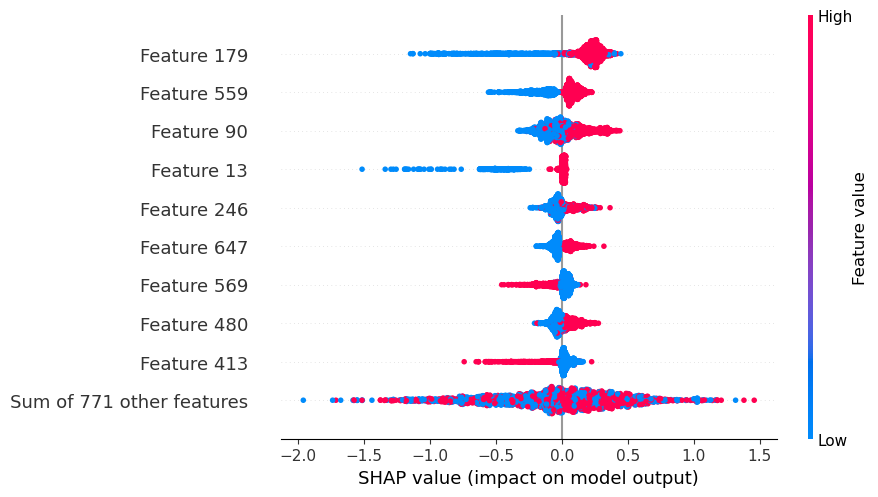

In [204]:
shap.plots.beeswarm(shap_values)

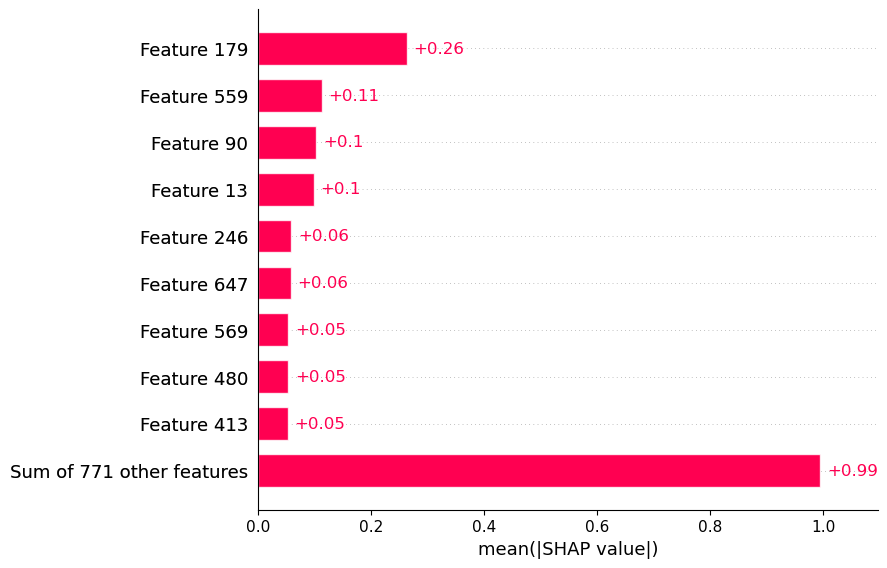

In [205]:
shap.plots.bar(shap_values)